Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


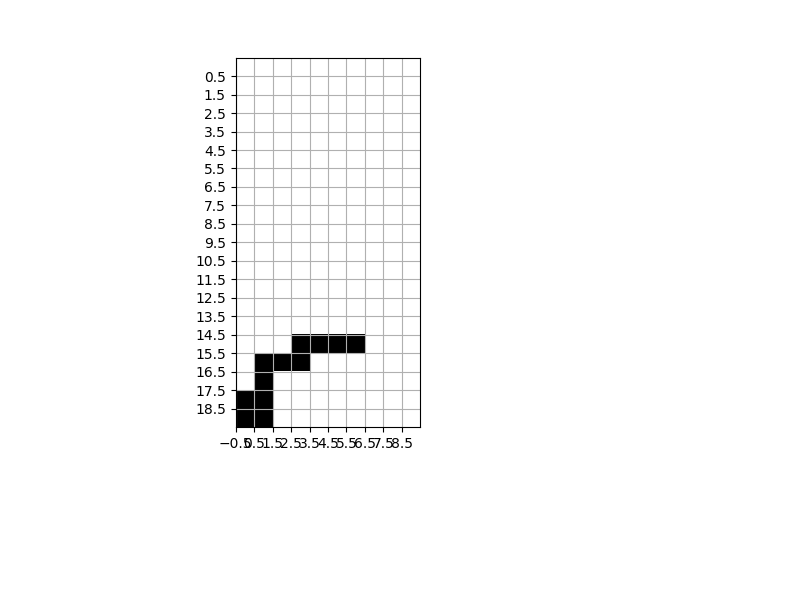

Episode 10/1000000 completed!
Average steps per episode: 20.8
Average lines cleared per episode: 0.0
Episode 20/1000000 completed!
Average steps per episode: 23.0
Average lines cleared per episode: 0.0
Episode 30/1000000 completed!
Average steps per episode: 22.1
Average lines cleared per episode: 0.0
Episode 40/1000000 completed!
Average steps per episode: 21.5
Average lines cleared per episode: 0.0
Episode 50/1000000 completed!
Average steps per episode: 26.4
Average lines cleared per episode: 0.1
Episode 60/1000000 completed!
Average steps per episode: 23.1
Average lines cleared per episode: 0.0


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import copy
%matplotlib notebook

# GPU if available

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BOARD_WIDTH = 10
BOARD_HEIGHT = 20
BLANK = 0

TEMPLATE_WIDTH = 5
TEMPLATE_HEIGHT = 5

S_SHAPE_TEMPLATE = [['.....',
                     '.....',
                     '..OO.',
                     '.OO..',
                     '.....'],
                    ['.....',
                     '..O..',
                     '..OO.',
                     '...O.',
                     '.....']]

Z_SHAPE_TEMPLATE = [['.....',
                     '.....',
                     '.OO..',
                     '..OO.',
                     '.....'],
                    ['.....',
                     '..O..',
                     '.OO..',
                     '.O...',
                     '.....']]

I_SHAPE_TEMPLATE = [['..O..',
                     '..O..',
                     '..O..',
                     '..O..',
                     '.....'],
                    ['.....',
                     '.....',
                     'OOOO.',
                     '.....',
                     '.....']]

O_SHAPE_TEMPLATE = [['.....',
                     '.....',
                     '.OO..',
                     '.OO..',
                     '.....']]

J_SHAPE_TEMPLATE = [['.....',
                     '.O...',
                     '.OOO.',
                     '.....',
                     '.....'],
                    ['.....',
                     '..OO.',
                     '..O..',
                     '..O..',
                     '.....'],
                    ['.....',
                     '.....',
                     '.OOO.',
                     '...O.',
                     '.....'],
                    ['.....',
                     '..O..',
                     '..O..',
                     '.OO..',
                     '.....']]

L_SHAPE_TEMPLATE = [['.....',
                     '...O.',
                     '.OOO.',
                     '.....',
                     '.....'],
                    ['.....',
                     '..O..',
                     '..O..',
                     '..OO.',
                     '.....'],
                    ['.....',
                     '.....',
                     '.OOO.',
                     '.O...',
                     '.....'],
                    ['.....',
                     '.OO..',
                     '..O..',
                     '..O..',
                     '.....']]

T_SHAPE_TEMPLATE = [['.....',
                     '..O..',
                     '.OOO.',
                     '.....',
                     '.....'],
                    ['.....',
                     '..O..',
                     '..OO.',
                     '..O..',
                     '.....'],
                    ['.....',
                     '.....',
                     '.OOO.',
                     '..O..',
                     '.....'],
                    ['.....',
                     '..O..',
                     '.OO..',
                     '..O..',
                     '.....']]

PIECES = {'S': S_SHAPE_TEMPLATE,
          'Z': Z_SHAPE_TEMPLATE,
          'J': J_SHAPE_TEMPLATE,
          'L': L_SHAPE_TEMPLATE,
          'I': I_SHAPE_TEMPLATE,
          'O': O_SHAPE_TEMPLATE,
          'T': T_SHAPE_TEMPLATE}

PIECES_IND = {'S': 0,
              'Z': 1,
              'J': 2,
              'L': 3,
              'I': 4,
              'O': 5,
              'T': 6}

PIECES_MARGINS = {'S': [[1, 1, 0], [0, 1, 1]],
                  'Z': [[1, 1, 0], [1, 0, 1]],
                  'J': [[1, 1, 1], [0, 1, 1], [1, 1, 0], [1, 0, 1]],
                  'L': [[1, 1, 1], [0, 1, 1], [1, 1, 0], [1, 0, 1]],
                  'I': [[0, 0, 2], [2, 1, 0]],
                  'O': [[1, 0, 0]],
                  'T': [[1, 1, 1], [0, 1, 1], [1, 1, 0], [1, 0, 1]]}


class Tetris:
    def __init__(self):
        self.board = self.getBlankBoard()
        self.current_piece = self.getNewPiece()

    def reset(self):
        """
        Restarts the game with a blank board and new piece.
        Returns: torch tensor
            A tensor representing the state.

        """
        self.board = self.getBlankBoard()
        self.current_piece = self.getNewPiece()
        return self.convertToFeatures(self.current_piece, self.board)

    def isOnBoard(self, x, y):
        """
        Checks if the position (x,y) is on the board.
        Args:
            x: int
                The x position
            y: int
                The y position

        Returns: Boolean
            If (x,y) is on the board.

        """
        return 0 <= x < BOARD_WIDTH and 0 <= y < BOARD_HEIGHT

    def getBlankBoard(self):
        return np.zeros((BOARD_WIDTH, BOARD_HEIGHT))

    def isValidPosition(self, board, piece, x, y, rotation):
        """
        Checks if a piece has a valid position on the board.
        Args:
            shape: str
                The shape of the tetris piece.
            x: int
                The x position of the piece.
            y: int
                The y position of the piece.
            rotation: int
                The rotation of the piece.

        Returns: Boolean
            If the piece has a valid position on the board.

        """
        for dx in range(TEMPLATE_WIDTH):
            for dy in range(TEMPLATE_HEIGHT):
                template = PIECES[piece][rotation % len(PIECES[piece])]
                if template[dy][dx] == 'O':
                    board_x_pos, board_y_pos = x + (dx - 2), y - (dy - 2)
                    if not self.isOnBoard(board_x_pos, board_y_pos) or board[board_x_pos][board_y_pos]:
                        return False
        return True

    def getNewPiece(self):
        return random.choice(list(PIECES.keys()))

    def findXYCoordinate(self, piece, action, board):
        rotation = action % 4
        left_margin, right_margin, top_margin = PIECES_MARGINS[piece][
            rotation % len(PIECES_MARGINS[piece])]
        x = max(left_margin, min(action // 4, BOARD_WIDTH - right_margin - 1))

        # Finding y coordinate to place the piece
        valid_y = None
        flag = False
        for y in range(BOARD_HEIGHT - top_margin - 1, -2, -1):
            if self.isValidPosition(board, piece, x, y, rotation):
                flag = True
            else:
                if flag:
                    valid_y = y + 1
                break

        return x, valid_y, rotation

    def transitionState(self, action):
        """
        Returns the next state given the action.
        Args:
            action: int
                An integer representing the action chosen.
                In total, there are BOARD_WIDTH x 4 actions, representing
                choices in the x coordinate and rotation of the piece.
                For a chosen x and rotation r, the action is 4 * x + r.

        Returns: tuple
            A tuple (reward, next_state, done) representing the reward, next state,
            and if the game has finished.

        """
        x, y, rotation = self.findXYCoordinate(self.current_piece, action, self.board)

        if y != None:
            self.board = self.placeOnBoard(self.current_piece, x, y, rotation, self.board)

            self.board, lines_cleared = self.clearLines(self.board)
            #delta_r, delta_c = self.countHoles()
            #reward = (lines_cleared**2/16 - delta_r/(BOARD_HEIGHT*BOARD_WIDTH) - delta_c/(BOARD_HEIGHT*BOARD_WIDTH))/2
            reward = 0.1 + (lines_cleared+1) ** 2

            self.current_piece = self.getNewPiece()
            next_state = self.convertToFeatures(self.current_piece, self.board)
            return reward, next_state, False, lines_cleared

        return 0, self.convertToFeatures(self.current_piece, self.board), True, 0

    def getAllNextStates(self):
        data = []
        for action in range(BOARD_WIDTH * 4):
            temp_board = copy.deepcopy(self.board)
            x, y, rotation = self.findXYCoordinate(self.current_piece, action, temp_board)
            if y != None:
                board = self.placeOnBoard(self.current_piece, x, y, rotation, temp_board)
                board, _ = self.clearLines(board)
                features = self.convertToFeatures(self.getNewPiece(), board)
                data.append((action, features))
        return data

    def placeOnBoard(self, piece, x, y, rotation, board):
        """
        Places the current piece on the board. Assumes that the piece
        is in a valid position.
        Args:
            x: int
                The x position of the piece.
            y: int
                The y position of the piece.
            rotation: int
                The rotation of the piece.

        Returns: None
        """
        template = PIECES[piece][rotation % len(PIECES[piece])]
        for dx in range(TEMPLATE_WIDTH):
            for dy in range(TEMPLATE_HEIGHT):
                if template[dy][dx] == 'O':
                    board_x_pos, board_y_pos = x + (dx - 2), y - (dy - 2)
                    board[board_x_pos][board_y_pos] = 1.0

        return board

    def clearLines(self, board):
        """
        Removes completed lines from the board.
        Returns: int
            The number of lines removed.

        """
        lines_removed = 0
        y = 0  # start y at the bottom of the board
        while y < BOARD_HEIGHT:
            if self.isCompleteLine(y, board):
                # Remove the line and pull boxes down by one line.
                for pull_down_Y in range(y, BOARD_HEIGHT - 1):
                    for x in range(BOARD_WIDTH):
                        board[x][pull_down_Y] = board[x][pull_down_Y + 1]
                # Set very top line to blank.
                for x in range(BOARD_WIDTH):
                    board[x][BOARD_HEIGHT - 1] = BLANK
                lines_removed += 1
                # Note on the next iteration of the loop, y is the same.
                # This is so that if the line that was pulled down is also
                # complete, it will be removed.
            else:
                y += 1  # move on to check next row up
        return board, lines_removed

    def isCompleteLine(self, y, board):
        """
        Checks if the line at height y is complete.
        Args:
            y: int
                The height of the row to check.

        Returns: Boolean
            True if the row is complete.

        """
        for x in range(BOARD_WIDTH):
            if board[x][y] == 0.0: return False
        return True

    def convertToFeatures(self, piece, board):
        """
        Converts the current board position and falling piece to a
        list of features.
        The features consist of:
            - 7 entries representing a 1 hot vector for the current piece.
            - BOARD_WIDTH entries representing the maximum height for each column.
            - BOARD_WIDTH - 1 entries representing the difference in heights between successive columns.
        Returns: torch tensor
            Torch tensor of the features described above. Values normalized to be between -1 and 1.

        """
        features = torch.zeros(len(PIECES) + 2 * BOARD_WIDTH - 1)

        # One hot vector for the current piece
        features[PIECES_IND[piece]] = 1.0

        # Maximum heights of each column
        for x in range(BOARD_WIDTH):
            for y in range(BOARD_HEIGHT - 1, -1, -1):
                if board[x][y]:
                    features[len(PIECES) + x] = y / BOARD_HEIGHT
                    break

        # Differences in heights between each column
        for x in range(BOARD_WIDTH - 1):
            features[len(PIECES) + BOARD_WIDTH + x] = features[len(PIECES) + x + 1] - features[len(PIECES) + x]

        return features.to(device)

    def countHoles(self):
        """
        Counts the number of transitions from filled to empty or vice
        versa in the rows and columns.
        Returns: tuple[int]
            A tuple (delta_r, delta_c) representing the number of transitions
            from filled to empty squares or vice versa across rows and columns respectively.

        """
        # Across rows:
        delta_r = 0
        for y in range(BOARD_HEIGHT):
            for x in range(BOARD_WIDTH - 1):
                if self.board[x][y] != self.board[x + 1][y]:
                    delta_r += 1

        # Across columns:
        delta_c = 0
        for x in range(BOARD_WIDTH):
            for y in range(BOARD_HEIGHT - 1):
                if self.board[x][y] != self.board[x][y + 1]:
                    delta_c += 1

        return delta_r, delta_c


class Agent:
    """ Agent object that uses the actor-critic network to find the
        optimal policy.
    """

    def __init__(self, env, NN):
        """ Initializes the agent.

            @type env: Tetris
                The Tetris environment.
            @type NN: NeuralNet
                Neural network for computing the state-action values.
            @type NN_pi: NeuralNet
                Neural network for computing the policy.
        """
        self.env = env
        self.NN = NN

    def chooseAction(self, epsilon):
        """ Chooses action. With probability epsilon it will choose
            an exploratory action. Otherwise, it will choose
            an action which maximizes the estimated reward of all
            possible next states.

            @type epsilon: float
                Exploration probability.
            @rtype: int
                An integer representing the action.
        """
        if random.uniform(0, 1) < epsilon:
            return random.randrange(BOARD_WIDTH * 4)

        cur_best_val = -float('inf')
        cur_best_action = 0

        data = env.getAllNextStates()

        for action, state in data:
            value = self.NN(state).item()
            if value > cur_best_val:
                cur_best_val = value
                cur_best_action = action

        return cur_best_action

    def initializeTrace(self):
        """
        Initializes the eligibility trace for the value network.
        @rtype: dict
            A dictionary that maps the layers of the value network
            to their eligibility traces.
        """
        z_w = {}
        with torch.no_grad():
            for p in self.NN.parameters():
                z_w[p] = torch.zeros(size=p.data.size()).to(device)

        return z_w

    def oneStep(self, state, delta, gamma, z, alpha, lmbda):
        """ Performs one training step on observed transition.
            @type state: torch tensor
                A torch tensor denoting the position.
            @type delta: float
                The TD error.
            @type gamma: float
                The discount factor.
            @type z: dict
                A dictionary that maps value model parameters to their
                eligibility traces.
            @type alpha: float
                The step size.
            @type lmbda: float
                Trace decay parameter.
            @rtype: dict
                A dictionary denoting the updated eligibility trace dictionary.
        """
        pred = self.NN(state)

        self.NN.zero_grad()

        pred[0].backward()

        # Update eligibility trace and parameters
        with torch.no_grad():
            for p in self.NN.parameters():
                z[p] = gamma * lmbda * z[p] + p.grad
                p.copy_(p + alpha * delta * z[p])

        return z

    def train(self, episodes, epsilon, gamma, alpha, lmbda):
        """ Trains the agent using the actor-critic method with eligibility traces.

            @type episodes: int
                The number of episodes to train.
            @type epsilon: float
                The exploration probability.
            @type gamma: float
                The discount factor.
            @type alpha: float
                Step size for the value network (critic).
            @type lmbda: float
                Trace decay parameter for the value network (critic).

        """
        %matplotlib

        fig = plt.gcf()
        fig.show()
        fig.canvas.draw()
        plt.grid()
        plt.xlim(-0.5, BOARD_WIDTH - 0.5)
        plt.ylim(BOARD_HEIGHT - 0.5, -0.5)

        tot_steps = 0

        LC = 0

        for episode in range(episodes):

            if (episode + 1) % 10 == 0:
                print(f'Episode {episode + 1}/{episodes} completed!')
                torch.save(self.NN.state_dict(), 'tetris_NN_value_model')
                print(f'Average steps per episode: {tot_steps / 10}')
                print(f'Average lines cleared per episode: {LC / 10}')

                tot_steps = 0
                LC = 0

            state, done = self.env.reset(), False

            # Initialize eligibility traces
            z = self.initializeTrace()

            while not done:
                tot_steps += 1

                time.sleep(0.2)
                plt.imshow(np.transpose(self.env.board)[::-1], cmap=plt.cm.binary, interpolation='none', origin='lower')
                ax = plt.gca()
                ax.set_xticks(np.arange(-0.5, BOARD_WIDTH - 0.5, 1))
                ax.set_yticks(np.arange(0.5, BOARD_HEIGHT - 0.5, 1))
                fig.canvas.draw()

                action = self.chooseAction(epsilon)

                reward, next_state, done, lines_cleared = self.env.transitionState(action)

                LC += lines_cleared

                # TD error
                target = reward + gamma * self.NN(next_state).item() if not done else reward
                delta = target - self.NN(state).item()

                z = self.oneStep(state, delta, gamma, z, alpha, lmbda)

                state = next_state


class QNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(QNetwork, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size1)
        self.l2 = nn.Linear(hidden_size1, hidden_size2)
        self.l3 = nn.Linear(hidden_size2, 1)

    def forward(self, x):
        x = torch.tanh(self.l1(x))
        x = torch.tanh(self.l2(x))
        x = self.l3(x)
        return x



if __name__ == "__main__":
    # Network parameters
    input_size = len(PIECES) + 2 * BOARD_WIDTH - 1
    hidden_size1 = 50
    hidden_size2 = 40

    # Training parameters
    episodes = 1000000
    gamma = 0.99
    alpha = 2e-4
    lmbda = 0.85
    epsilon = 0.1

    env = Tetris()
    model_value = QNetwork(input_size, hidden_size1, hidden_size2).to(device)

    #model_value.load_state_dict(torch.load('tetris_NN_value_model'))

    tetris_agent = Agent(env, model_value)

    tetris_agent.train(episodes, epsilon, gamma, alpha, lmbda)